Total samples: 15000
Train: 9000, Val: 3000, Test: 3000
Epoch   1 | Train Loss: 0.246172 | Val Loss: 0.002603 | LR: 0.0001
  → New best val loss: 0.002603, saved to ./best_vit50_3block.pth
Epoch   2 | Train Loss: 0.001184 | Val Loss: 0.001237 | LR: 0.0001
  → New best val loss: 0.001237, saved to ./best_vit50_3block.pth
Epoch   3 | Train Loss: 0.001149 | Val Loss: 0.002507 | LR: 0.0001
Epoch   4 | Train Loss: 0.000826 | Val Loss: 0.000589 | LR: 0.0001
  → New best val loss: 0.000589, saved to ./best_vit50_3block.pth
Epoch   5 | Train Loss: 0.000780 | Val Loss: 0.000861 | LR: 0.0001
Epoch   6 | Train Loss: 0.000595 | Val Loss: 0.000751 | LR: 0.0001
Epoch   7 | Train Loss: 0.000542 | Val Loss: 0.000572 | LR: 0.0001
  → New best val loss: 0.000572, saved to ./best_vit50_3block.pth
Epoch   8 | Train Loss: 0.000451 | Val Loss: 0.000528 | LR: 0.0001
  → New best val loss: 0.000528, saved to ./best_vit50_3block.pth
Epoch   9 | Train Loss: 0.000538 | Val Loss: 0.000451 | LR: 0.0001
  → New bes

/tmp/ipykernel_80200/3189131320.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


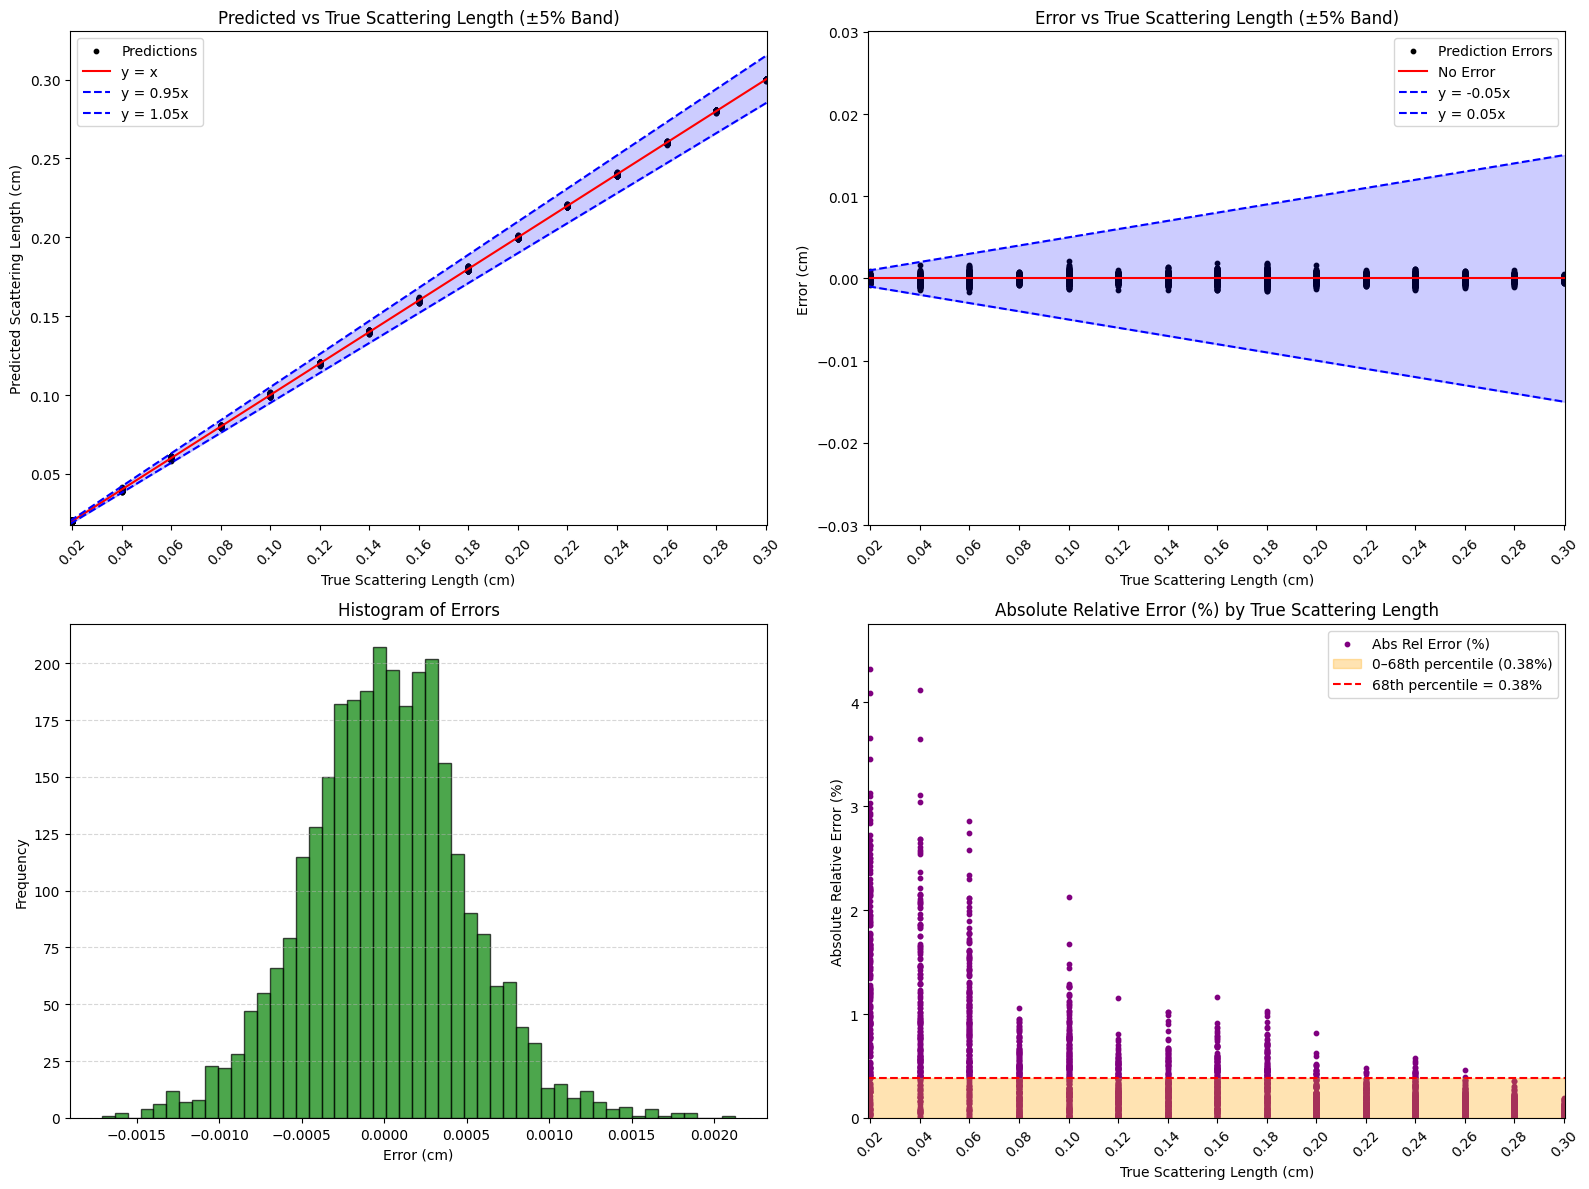

In [ ]:
import os
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torchvision.transforms as T

# ─────────────────────────────────────────────────────────────────────────────
# 1) Dataset definition: Use 500×500 images as-is, without PatchEmbedding
# ─────────────────────────────────────────────────────────────────────────────
class NoisyImageDataset(Dataset):
    def __init__(self, images, labels, lbl_min, lbl_max):
        """
        images: (N, 500, 500) numpy array, raw pixel values (0~4095)
        labels: (N,) numpy array, raw labels
        lbl_min, lbl_max: Label min–max normalization constants
        """
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.float32)
        self.lbl_min = lbl_min
        self.lbl_max = lbl_max
        self.to_tensor = T.ToTensor()  # (H, W) → (1, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]   # (500, 500)
        lbl = self.labels[idx]   # float

        # 1) [0,4095] → [0,1]
        img_norm = img / 4095.0

        # 2) Grayscale → Tensor (1, 500, 500)
        img_tensor = self.to_tensor(img_norm)

        # 3) Label min–max normalization → [-1,1]
        lbl_norm = (lbl - self.lbl_min) / (self.lbl_max - self.lbl_min + 1e-8)  # [0,1]
        lbl_scaled = lbl_norm * 2.0 - 1.0                                       # [-1,1]
        lbl_tensor = torch.tensor(lbl_scaled, dtype=torch.float32)

        return img_tensor, lbl_tensor


# ─────────────────────────────────────────────────────────────────────────────
# 2) ViT model definition: patch size 50, 3 Transformer blocks
# ─────────────────────────────────────────────────────────────────────────────
class ViT50_3block(nn.Module):
    def __init__(self,
                 img_size=500,
                 patch_size=50,
                 embed_dim=256,
                 depth=3,
                 num_heads=8,
                 mlp_dim=512,
                 num_classes=1):
        """
        img_size: Input image resolution (here, 500×500)
        patch_size: Each patch size (50×50)
        embed_dim: Patch embedding dimension (256 here)
        depth: Number of Transformer Encoder layers (3)
        num_heads: Number of multi-head attention heads (8)
        mlp_dim: Hidden dimension of MLP within Transformer (512)
        num_classes: Output nodes (1 for regression)
        """
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size."
        num_patches = (img_size // patch_size) ** 2  # (500/50)² = 10×10 = 100

        # 2-1) Patch Embedding: Conv2d(1→embed_dim, kernel=patch_size, stride=patch_size)
        self.patch_embed = nn.Conv2d(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        # Output: (B, embed_dim, 10, 10)

        # 2-2) Learnable class token parameter
        #   (A learnable token added to the beginning of the sequence, shape=(1,1,embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # 2-3) Positional Embedding: (1, num_patches+1, embed_dim)
        #   Sequence length = number of patches(100) + cls token(1) = 101
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # 2-4) Transformer Encoder: 3 layers (repeat nn.TransformerEncoderLayer)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=0.0,
            activation='gelu',
            batch_first=False  # Expects input as (seq_len, batch, embed_dim)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 2-5) Regression Head: Transformer CLS output (256 dim) → Linear(256→1)
        self.head = nn.Linear(embed_dim, num_classes)

        # 2-6) Parameter initialization
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        """
        x: (B, 1, 500, 500)
        """
        B = x.size(0)

        # (1) Patch Embedding
        #    Input (B,1,500,500) → Conv2d → (B, embed_dim, 10, 10)
        x = self.patch_embed(x)

        # (2) Flatten & Transpose
        #    (B, embed_dim, 10, 10) → (B, embed_dim, 100) → (B, 100, embed_dim)
        x = x.flatten(2).transpose(1, 2)

        # (3) Add CLS token
        #    cls_token (1,1,embed_dim) → expand → (B,1,embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        #    (B,1,embed_dim) + (B,100,embed_dim) → (B,101,embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)

        # (4) Add positional embedding
        #    pos_embed (1,101,embed_dim) → broadcast → (B,101,embed_dim)
        x = x + self.pos_embed

        # (5) Transformer encoder expects (seq_len, batch, embed_dim)
        x = x.transpose(0, 1)  # (101, B, embed_dim)
        x = self.transformer(x)  # (101, B, embed_dim)

        # (6) Use only the CLS token output: x[0] → (B, embed_dim)
        cls_out = x[0]

        # (7) Regression Head: (B, embed_dim) → (B, 1) → squeeze → (B,)
        out = self.head(cls_out).squeeze(-1)
        return out


# ─────────────────────────────────────────────────────────────────────────────
# 3) train_validate function: Early Stopping + ReduceLROnPlateau + AdamW
# ─────────────────────────────────────────────────────────────────────────────
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler,
                   num_epochs=100, patience=10, save_path='./best_vit50_3block.pth'):
    device = next(model.parameters()).device
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(1, num_epochs + 1):
        # ─── Training ─────────────────────────────────────────────────────
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)

            optimizer.zero_grad()
            outputs = model(images)      # (B,)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)

        # ─── Validation ───────────────────────────────────────────────────
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        val_loss   = running_val_loss   / len(val_loader.dataset)
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {lr:.6g}")

        # ─── Update ReduceLROnPlateau scheduler ──────────────────────────
        #    scheduler.step(val_loss) → reduce LR based on val_loss
        scheduler.step(val_loss)

        # ─── Early Stopping and Best Model Saving ────────────────────────
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), save_path)
            print(f"  → New best val loss: {best_val_loss:.6f}, saved to {save_path}")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return model


# ─────────────────────────────────────────────────────────────────────────────
# 4) Full pipeline: Load data → DataLoader → Define model → Train → Evaluate → Visualize
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    # (A) Load HDF5
    hdf5_path = '/home/work/CamSim/SimData_Hole/ICRC_Data/beam_80/hr_0.5_1000.h5'
    with h5py.File(hdf5_path, 'r') as f:
        raw_images = f['images'][:]   # (N, 500, 500)
        raw_labels = f['labels'][:]   # (N,)

    print(f"Total samples: {raw_images.shape[0]}")

    # Compute label min/max
    lbl_min = raw_labels.min()
    lbl_max = raw_labels.max()

    # (B) Create Dataset & DataLoader (60/20/20 split)
    dataset = NoisyImageDataset(raw_images, raw_labels, lbl_min, lbl_max)
    unique_labels = np.unique(raw_labels)

    train_indices, val_indices, test_indices = [], [], []
    for lbl in unique_labels:
        inds = np.where(raw_labels == lbl)[0].tolist()
        random.shuffle(inds)
        n = len(inds)
        n_test = int(n * 0.20)
        n_val  = int(n * 0.20)
        test_indices.extend(inds[:n_test])
        val_indices.extend(inds[n_test:n_test + n_val])
        train_indices.extend(inds[n_test + n_val:])

    batch_size = 32
    train_loader = DataLoader(Subset(dataset, train_indices),
                              batch_size=batch_size, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader   = DataLoader(Subset(dataset, val_indices),
                              batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)
    test_loader  = DataLoader(Subset(dataset, test_indices),
                              batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)

    print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

    # (C) Define model: ViT50_3block
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ViT50_3block(
        img_size=500,
        patch_size=50,
        embed_dim=128,
        depth=3,
        num_heads=8,
        mlp_dim=512,
        num_classes=1
    ).to(device)

    # (D) Optimizer & Scheduler: AdamW + ReduceLROnPlateau
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',
                                  factor=0.5,
                                  patience=4,
                                  verbose=True)

    # (E) Model training
    best_model_path = './best_vit50_3block.pth'
    model = train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        num_epochs=100,
        patience=10,
        save_path=best_model_path
    )

    # (F) Test set evaluation
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    true_vals = []
    pred_vals = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)
            outputs = model(images)      # (B,)

            # Denormalize → back to original scale
            labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
            preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

            true_vals.extend(labels_orig.tolist())
            pred_vals.extend(preds_orig.tolist())

    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    errors = pred_vals - true_vals
    abs_rel_errors = np.abs(errors / true_vals) * 100.0

    # (G) Visualization of results
    plt.figure(figsize=(16, 12))
    mn = min(true_vals.min(), pred_vals.min())
    mx = max(true_vals.max(), pred_vals.max())
    unique_true_labels = np.unique(true_vals)

    # 1) Predicted vs True with ±5% Band
    ax1 = plt.subplot(2, 2, 1)
    ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
    ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
    ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
    ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
    ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
    ax1.set_xticks(unique_true_labels)
    ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
    ax1.set_xlabel("True Scattering Length (cm)")
    ax1.set_ylabel("Predicted Scattering Length (cm)")
    ax1.set_xlim(mn, mx)
    ax1.set_ylim(mn * 0.9, mx * 1.1)
    ax1.legend()

    # 2) Error vs True with ±5% Band
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
    ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
    ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
    ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
    ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
    ax2.set_xticks(unique_true_labels)
    ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax2.set_title("Error vs True Scattering Length (±5% Band)")
    ax2.set_xlabel("True Scattering Length (cm)")
    ax2.set_ylabel("Error (cm)")
    ax2.set_xlim(mn, mx)
    ax2.set_ylim(-0.1 * mx, 0.1 * mx)
    ax2.legend()

    # 3) Histogram of Errors (50 bins)
    ax3 = plt.subplot(2, 2, 3)
    bins = np.linspace(errors.min(), errors.max(), 50)
    ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
    ax3.set_title("Histogram of Errors")
    ax3.set_xlabel("Error (cm)")
    ax3.set_ylabel("Frequency")
    ax3.grid(axis='y', linestyle='--', alpha=0.5)

    # 4) Absolute Relative Error (%) by True with 68th Percentile
    ax4 = plt.subplot(2, 2, 4)
    ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
    perc68 = np.percentile(abs_rel_errors, 68)
    ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                     label=f'0–68th percentile ({perc68:.2f}%)')
    ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
               label=f'68th percentile = {perc68:.2f}%')
    ax4.set_xticks(unique_true_labels)
    ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
    ax4.set_xlabel("True Scattering Length (cm)")
    ax4.set_ylabel("Absolute Relative Error (%)")
    ax4.set_xlim(mn, mx)
    ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
    ax4.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Define ViT50_3block, optimizer, and scheduler the same as before
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (A) Model definition
model = ViT50_3block(
    img_size=500,
    patch_size=50,
    embed_dim=128,   # Must match the value used during training
    depth=3,
    num_heads=8,
    mlp_dim=512,
    num_classes=1
).to(device)

# (B) Optimizer + Scheduler
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=4,
    verbose=True
)

criterion = nn.MSELoss()

# ─────────────────────────────────────────────────────────────────────────────
# 2) Load checkpoint
#    (Specify the best model file saved from the train_validate function)
# ─────────────────────────────────────────────────────────────────────────────
best_model_path = './best_vit50_3block.pth'
checkpoint = torch.load(best_model_path, map_location=device)

# Check if checkpoint is a dictionary (full checkpoint) or just a state_dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    # Format: {'model_state_dict': ..., 'optimizer_state_dict': ..., 'val_loss': ..., ...}
    model.load_state_dict(checkpoint['model_state_dict'])
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 0)}. Continuing from epoch {start_epoch}.")
else:
    # If only model.state_dict() was saved
    model.load_state_dict(checkpoint)
    start_epoch = 1
    best_val_loss = float('inf')
    print("Loaded state_dict-only checkpoint. Starting from epoch 1.")

# ─────────────────────────────────────────────────────────────────────────────
# 3) Number of additional epochs and Early Stopping variables
# ─────────────────────────────────────────────────────────────────────────────
additional_epochs = 50
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# ─────────────────────────────────────────────────────────────────────────────
# 4) Resume training loop
# ─────────────────────────────────────────────────────────────────────────────
for epoch in range(start_epoch, total_epochs + 1):
    # ---- Training ----
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)

        optimizer.zero_grad()
        outputs = model(images)      # (B,)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # ---- Update ReduceLROnPlateau scheduler ----
    scheduler.step(val_loss)

    # ---- Early Stopping and checkpoint update ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# ─────────────────────────────────────────────────────────────────────────────
# 5) Save the final model
# ─────────────────────────────────────────────────────────────────────────────
final_save_path = best_model_path.re


Loaded state_dict-only checkpoint. Starting from epoch 1.


/tmp/ipykernel_80200/2230825027.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


[Epoch 1/50] Train Loss: 0.000082 | Val Loss: 0.000026 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/50] Train Loss: 0.000032 | Val Loss: 0.000045 | LR: 0.0001
[Epoch 3/50] Train Loss: 0.000030 | Val Loss: 0.000018 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 3.
[Epoch 4/50] Train Loss: 0.000045 | Val Loss: 0.000028 | LR: 0.0001
[Epoch 5/50] Train Loss: 0.000042 | Val Loss: 0.000289 | LR: 0.0001
[Epoch 6/50] Train Loss: 0.000040 | Val Loss: 0.000012 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 6.
[Epoch 7/50] Train Loss: 0.000015 | Val Loss: 0.000043 | LR: 0.0001
[Epoch 8/50] Train Loss: 0.000017 | Val Loss: 0.000023 | LR: 0.0001
[Epoch 9/50] Train Loss: 0.000038 | Val Loss: 0.000016 | LR: 0.0001
[Epoch 10/50] Train Loss: 0.000021 | Val Loss: 0.000025 | LR: 0.0001
[Epoch 11/50] Train Loss: 0.000015 | Val Loss: 0.000012 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 11.
[Epoch 12/50] Train Loss: 0.00002

/tmp/ipykernel_80200/1237274658.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


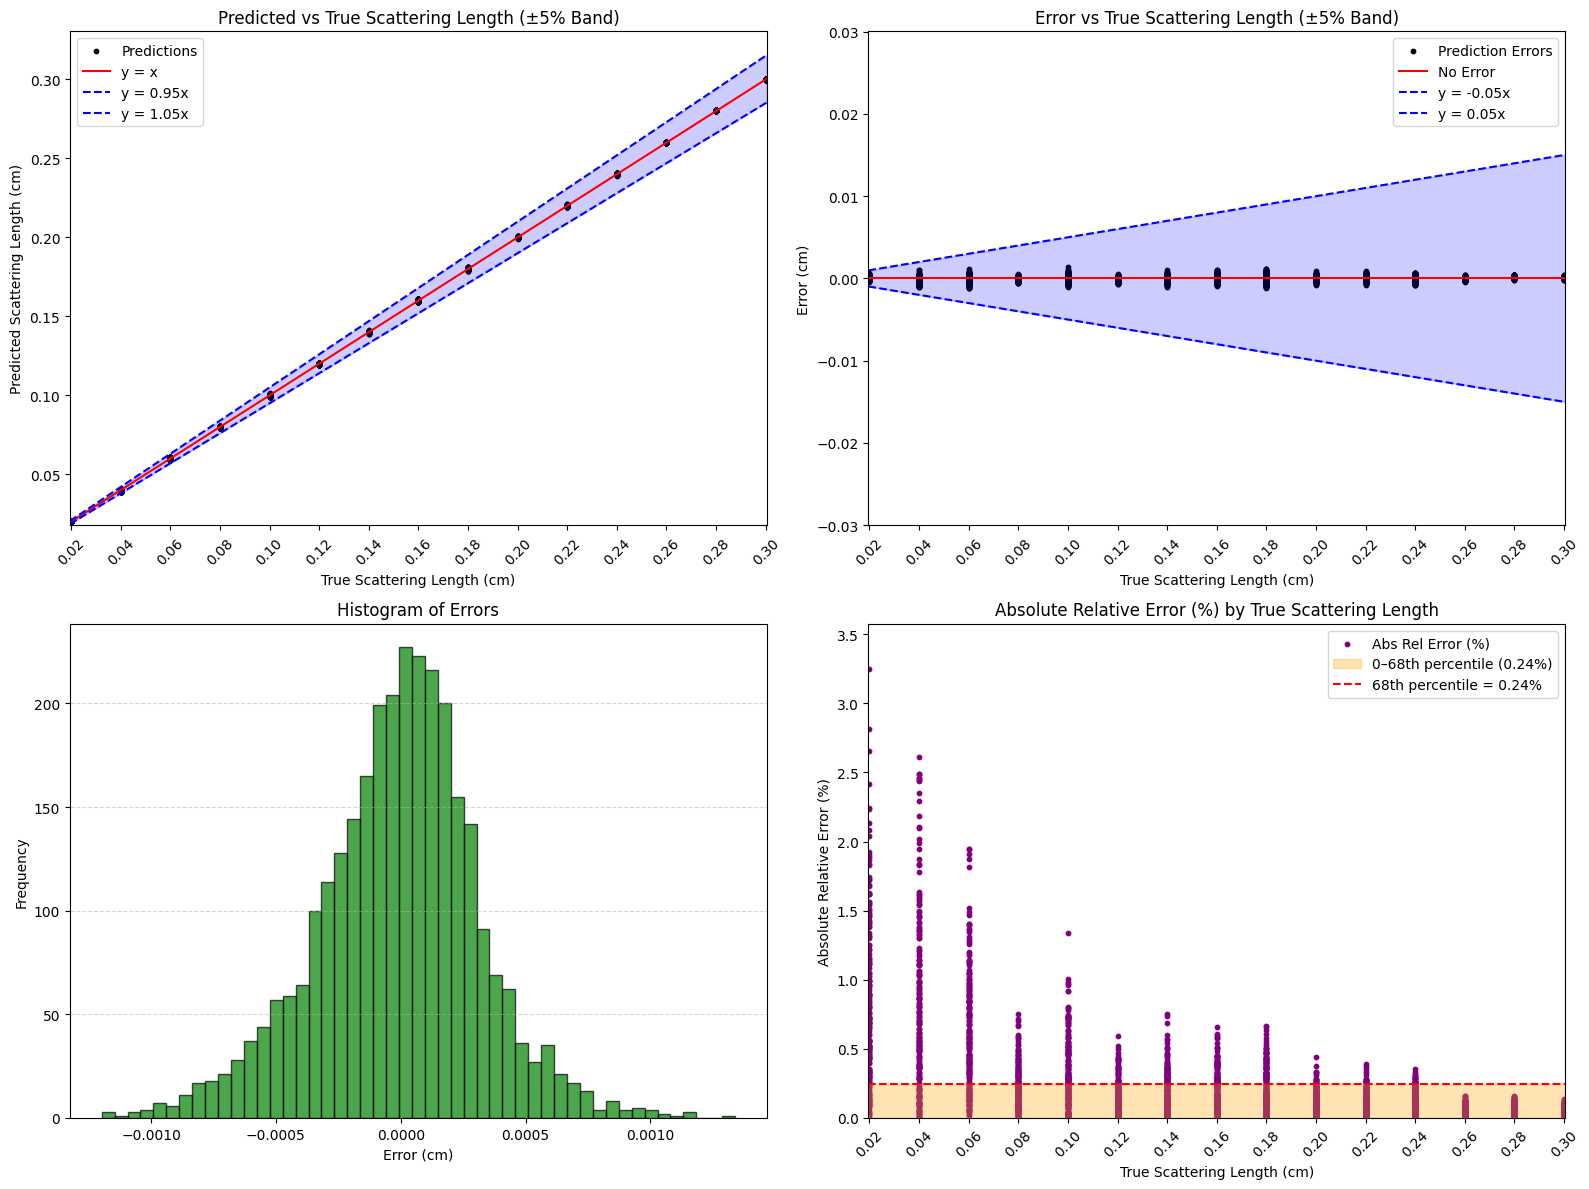

In [ ]:
best_model_path = "/home/work/CamSim/Deep-Learning/best_vit50_3block_resumed_final.pth"

# 1) Load checkpoint
checkpoint = torch.load(best_model_path, map_location=device)

# 2) Load only the model_state_dict
model.load_state_dict(checkpoint['model_state_dict'])

# (Optional) Restore optimizer and scheduler states as well, if desired.
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # Denormalize → back to original scale
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) Result visualization
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()